# Introduction
In this project we will build recommendations for new restaurants about where to open in New York, based on the areas with most visited restaurants.

## Scrap New York city data

Import libraries

In [3]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    folium-0.11.0              |             py_0          61 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    branca:          0.4.1-py_0        conda-forge
    folium:          

Data sources used :<br>
https://en.wikipedia.org/wiki/New_York_City<br>
https://en.wikipedia.org/wiki/Demographics_of_New_York_City

In [49]:
response_obj = requests.get('https://en.wikipedia.org/wiki/New_York_City').text
soup = BeautifulSoup(response_obj,'lxml')
Neighborhoods_NYC_Table = soup.find('table', {'class':'wikitable sortable'})

In [50]:
rows = Neighborhoods_NYC_Table.select("tbody > tr")[3:8]

boroughs = []
for row in rows:
    borough = {}
    
    tds = row.select('td')
    borough["borough"] = tds[0].text.strip()
    borough["county"] = tds[1].text.strip()
    borough["population"] = float(tds[2].text.strip().replace(",",""))
    borough["gdp_billions"] = float(tds[3].text.strip().replace(",",""))
    borough["gdp_per_capita"] = float(tds[4].text.strip().replace(",",""))
    borough["land_sqm"] = float(tds[5].text.strip().replace(",",""))
    borough["land_sqkm"] = float(tds[6].text.strip().replace(",",""))
    borough["persons_sqm"] = float(tds[7].text.strip().replace(",",""))
    borough["persons_sqkm"] = float(tds[8].text.strip().replace(",",""))
    
    boroughs.append(borough)

print(boroughs)

[{'borough': 'The Bronx', 'county': 'Bronx', 'population': 1418207.0, 'gdp_billions': 42.695, 'gdp_per_capita': 30100.0, 'land_sqm': 42.1, 'land_sqkm': 109.04, 'persons_sqm': 33867.0, 'persons_sqkm': 13006.0}, {'borough': 'Brooklyn', 'county': 'Kings', 'population': 2559903.0, 'gdp_billions': 91.559, 'gdp_per_capita': 35800.0, 'land_sqm': 70.82, 'land_sqkm': 183.42, 'persons_sqm': 36147.0, 'persons_sqkm': 13957.0}, {'borough': 'Manhattan', 'county': 'New York', 'population': 1628706.0, 'gdp_billions': 600.244, 'gdp_per_capita': 368500.0, 'land_sqm': 22.83, 'land_sqkm': 59.13, 'persons_sqm': 71341.0, 'persons_sqkm': 27544.0}, {'borough': 'Queens', 'county': 'Queens', 'population': 2253858.0, 'gdp_billions': 93.31, 'gdp_per_capita': 41400.0, 'land_sqm': 108.53, 'land_sqkm': 281.09, 'persons_sqm': 20767.0, 'persons_sqkm': 8018.0}, {'borough': 'Staten Island', 'county': 'Richmond', 'population': 476143.0, 'gdp_billions': 14.514, 'gdp_per_capita': 30500.0, 'land_sqm': 58.37, 'land_sqkm': 15

In [51]:
response_obj = requests.get('https://en.wikipedia.org/wiki/Demographics_of_New_York_City').text
soup = BeautifulSoup(response_obj,'lxml')
Population_Census_Table = soup.select_one('.wikitable:nth-of-type(5)') #use css selector to target correct table.

jurisdictions = []
rows = Population_Census_Table.select("tbody > tr")[3:8]
for row in rows:
    jurisdiction = {}
    tds = row.select('td')
    jurisdiction["jurisdiction"] = tds[0].text.strip()
    jurisdiction["population_census"] = tds[1].text.strip()
    jurisdiction["%_white"] = float(tds[2].text.strip().replace(",",""))
    jurisdiction["%_black_or_african_amercian"] = float(tds[3].text.strip().replace(",",""))
    jurisdiction["%_Asian"] = float(tds[4].text.strip().replace(",",""))
    jurisdiction["%_other"] = float(tds[5].text.strip().replace(",",""))
    jurisdiction["%_mixed_race"] = float(tds[6].text.strip().replace(",",""))
    jurisdiction["%_hispanic_latino_of_other_race"] = float(tds[7].text.strip().replace(",",""))
    jurisdiction["%_catholic"] = float(tds[10].text.strip().replace(",",""))
    jurisdiction["%_jewish"] = float(tds[12].text.strip().replace(",",""))
    jurisdictions.append(jurisdiction)

print(jurisdictions)

[{'jurisdiction': 'Queens', 'population_census': '2,229,379', '%_white': 44.1, '%_black_or_african_amercian': 20.0, '%_Asian': 17.6, '%_other': 12.3, '%_mixed_race': 6.1, '%_hispanic_latino_of_other_race': 25.0, '%_catholic': 37.0, '%_jewish': 5.0}, {'jurisdiction': 'Manhattan', 'population_census': '1,537,195', '%_white': 54.4, '%_black_or_african_amercian': 17.4, '%_Asian': 9.4, '%_other': 14.7, '%_mixed_race': 4.1, '%_hispanic_latino_of_other_race': 27.2, '%_catholic': 11.0, '%_jewish': 9.0}, {'jurisdiction': 'Bronx', 'population_census': '1,332,650', '%_white': 29.9, '%_black_or_african_amercian': 35.6, '%_Asian': 3.0, '%_other': 25.7, '%_mixed_race': 5.8, '%_hispanic_latino_of_other_race': 48.4, '%_catholic': 14.0, '%_jewish': 5.0}, {'jurisdiction': 'Staten Island', 'population_census': '443,728', '%_white': 77.6, '%_black_or_african_amercian': 9.7, '%_Asian': 5.7, '%_other': 4.3, '%_mixed_race': 2.7, '%_hispanic_latino_of_other_race': 12.1, '%_catholic': 11.0, '%_jewish': 5.0}, {

In [52]:
df = pd.DataFrame(jurisdictions, columns=["jurisdiction","%_white", "%_black_or_african_amercian", "%_Asian", "%_other", "%_mixed_race", "%_hispanic_latino_of_other_race"])
df.head()

,jurisdiction,%_white,%_black_or_african_amercian,%_Asian,%_other,%_mixed_race,%_hispanic_latino_of_other_race
0,Queens,44.1,20.0,17.6,12.3,6.1,25.0
1,Manhattan,54.4,17.4,9.4,14.7,4.1,27.2
2,Bronx,29.9,35.6,3.0,25.7,5.8,48.4
3,Staten Island,77.6,9.7,5.7,4.3,2.7,12.1
4,NYC Total,44.7,26.6,9.8,14.0,4.9,27.0


**FourSquare API is used to find neighborhoods & New York City data that contains list Boroughs, Neighbourhoods and their latitude and longitude.**

Define a function to get geo location of address

In [53]:
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to get top 100 venues within a radius of 1000 metres for a given latitude and longitude

In [68]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'SJVNROHFKAQ0CZ5ULIM0V5K5IXUPI2UV1FARMVENUHS3HB4F'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='W1H0JXEDQWHBWX1ZZYT2IXCRTWLGPSNQ2NOGQ5IA4ZKCQKEU' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a function to get venue details

In [69]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'SJVNROHFKAQ0CZ5ULIM0V5K5IXUPI2UV1FARMVENUHS3HB4F'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='W1H0JXEDQWHBWX1ZZYT2IXCRTWLGPSNQ2NOGQ5IA4ZKCQKEU' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a funtion to get boroughs and neighborhoods in New York city and their latitude and longitude

In [70]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [71]:
#retrieve data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [58]:
new_york_data.shape

(306, 4)

There 306 different neighborhoods in New York, plot data to show the most populated borough

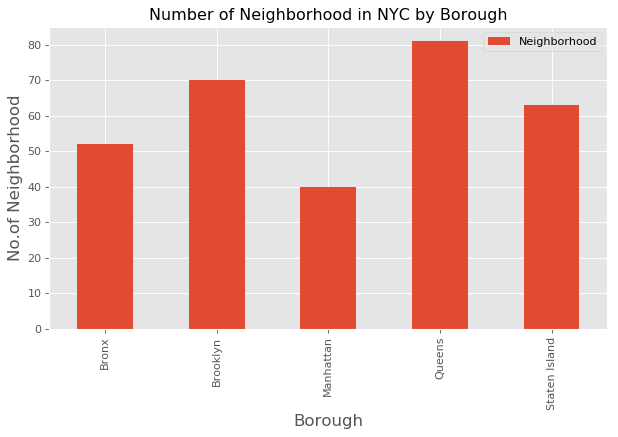

In [59]:
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighborhood in NYC by Borough')
#Borough in x-axis
plt.xlabel('Borough', fontsize = 15)
#Sum of neighborhoods in y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)

new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')

plt.legend()
plt.show()

We can find that Queens is the most populated borough with the largest number of neighborhoods.

Now prepare neighborhood list that contains chinese restaurant.

In [72]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [73]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,Bronx,Wakefield,4b897beff964a520c43a32e3,Mandarin House
2,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet
3,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
4,Bronx,Norwood,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant


In [75]:
chinese_rest_ny.shape

(405, 4)

Next, plot data to show the borough with the most chinese restaurants

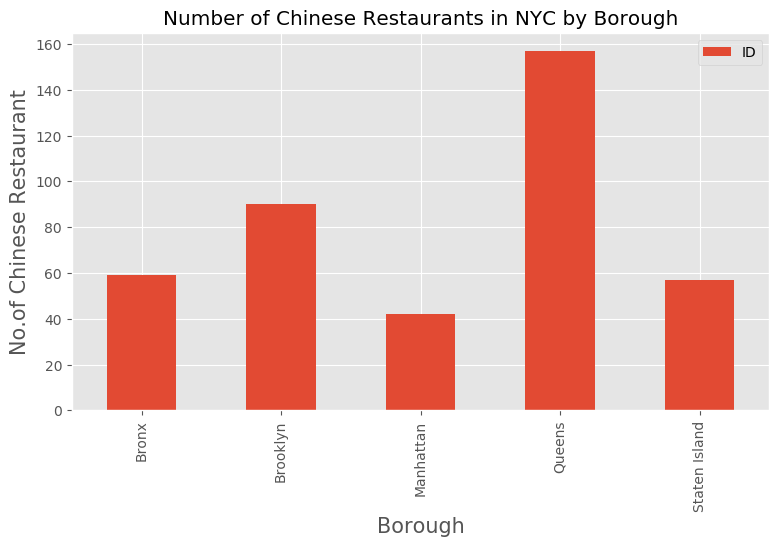

In [76]:
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Restaurant', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We can see that Queens is the borough with the most Chinese restaurants

In [79]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Flushing']

,Borough,Neighborhood,ID,Name
162,Queens,Flushing,5747a89b498ee4b7a5106556,DunHuang Lanzhou Beef Noodle
163,Queens,Flushing,4fa3f81be4b0a34ac673bf1e,Taipei Hong 台北夯
164,Queens,Flushing,52235ea211d2fe55782d764c,Dong Yi Feng
165,Queens,Flushing,4ad50f59f964a520950121e3,Fu Run 賦潤東北美食
166,Queens,Flushing,4abfef82f964a520179320e3,New Imperial Palace 東湖
167,Queens,Flushing,4c78756397028cfaec16d8fe,New Golden Szechuan Chinese Restaurant
168,Queens,Flushing,4faff7eae4b03b8055801cde,Xi'an Famous Foods
169,Queens,Flushing,4a1845c8f964a52092791fe3,Asian Jewels Seafood Restaurant 敦城海鲜酒家
170,Queens,Flushing,4d1bcddc1356224bc6410abe,OK Ryan
171,Queens,Flushing,4ef37491d3e32dc398c7c5c7,Laoma Mala Tang


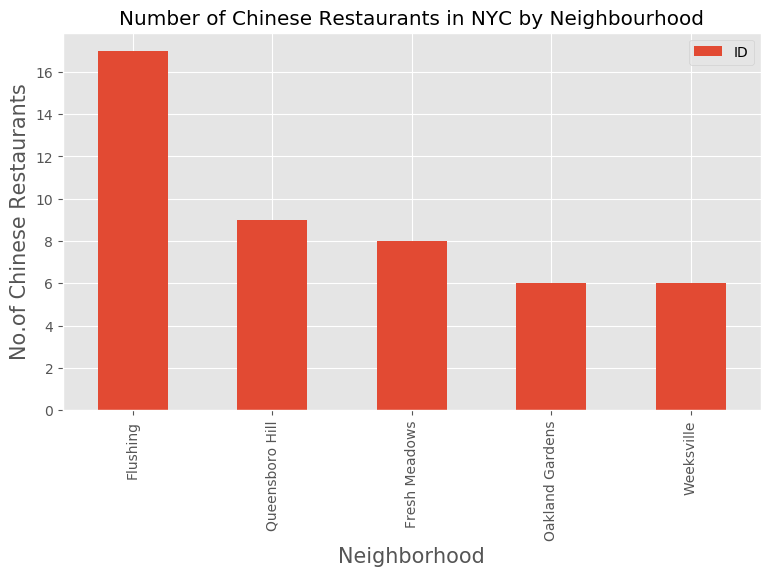

In [78]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Restaurants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Flushing in Queens has the most Chinese Restaurants with a total count of 17. </br>
Now prepare neighborhood list that contain Chinese restaurants.

In [80]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4edbac4e775bcc53fc0ed5f8
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4b897beff964a520c43a32e3
                         ID            Name  Likes  Rating  Tips
0  4c66dcfaaebea593955a74d0  Chinese Buffet      7     5.2    10
                         ID                           Name  Likes  Rating  \
0  4d965fd061a3a1cde4989a42  Lucky Star Chinese Restaurant      3     7.3   

   Tips  
0     5  
                         ID                            Name  Likes  Rating  \
0  4e2e08021838f1c552b6b8eb  Choi Yuan - Chinese Restaurant      6     6.3   

   Tips  
0     8  
                         ID                          Name  Likes  Rating  Tips
0  4e4d0387bd413c4cc66dfd72  Hung Hing Chinese Restaurant      5     6.2     2
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e6aa73eaeb7c31e43294be9
      

In [90]:
chinese_rest_stats_ny.drop(chinese_rest_stats_ny[chinese_rest_stats_ny.ID == 0].index, inplace=True)
chinese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
2,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet,7.0,7.0,7.0
3,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,3.0,3.0,3.0
4,Bronx,Norwood,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant,6.0,6.0,6.0
5,Bronx,Norwood,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant,5.0,5.0,5.0
7,Bronx,Baychester,4c1a8bac8b3aa593a8c8955f,Dragon City,1.0,1.0,1.0


In [93]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 2 to 45
Data columns (total 7 columns):
Borough         16 non-null object
Neighborhood    16 non-null object
ID              16 non-null object
Name            16 non-null object
Likes           16 non-null object
Rating          16 non-null object
Tips            16 non-null object
dtypes: object(7)
memory usage: 1.0+ KB


In [94]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Likes'].astype('float64')

In [95]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 2 to 45
Data columns (total 7 columns):
Borough         16 non-null object
Neighborhood    16 non-null object
ID              16 non-null object
Name            16 non-null object
Likes           16 non-null float64
Rating          16 non-null float64
Tips            16 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.0+ KB


**Restaurants with maximum Likes**

In [101]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                     Fordham
ID              566f33e7498e44c2501bda81
Name                       Panda Express
Likes                                 12
Rating                                12
Tips                                  12
Name: 9, dtype: object

**Restaurants with maximum Rating**

In [103]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                     Fordham
ID              566f33e7498e44c2501bda81
Name                       Panda Express
Likes                                 12
Rating                                12
Tips                                  12
Name: 9, dtype: object

**Restaurants with maximum Tips**

In [104]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                     Fordham
ID              566f33e7498e44c2501bda81
Name                       Panda Express
Likes                                 12
Rating                                12
Tips                                  12
Name: 9, dtype: object

In [117]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [118]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
5,Fordham,12.0
7,Melrose,12.0
11,Pelham Parkway,9.0
3,Co-op City,7.0
2,City Island,6.0
1,Bedford Park,5.5
9,Norwood,5.5
4,Concourse,5.0
10,Parkchester,5.0
12,Unionport,5.0


In [119]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [120]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,6.0
1,Manhattan,3.0


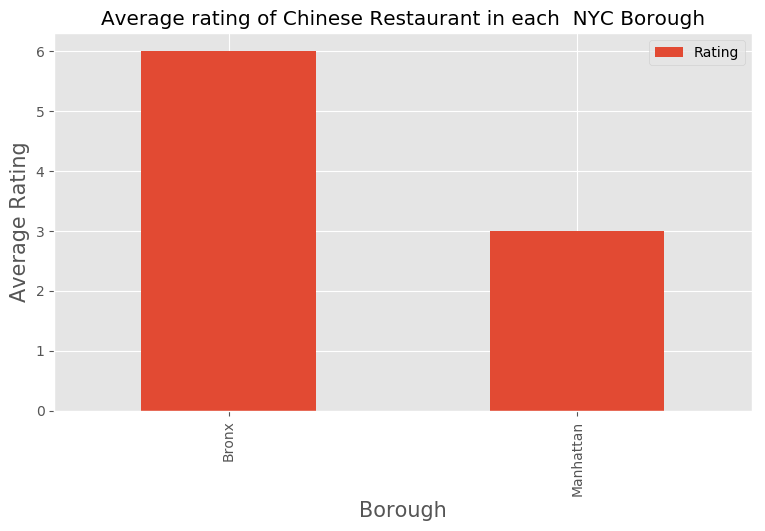

In [109]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We can find Bronx has the highest average rating for Chinese Restaurants.

**Visualize all the neighborhoods with average rating greater or equal 7 on map**

In [122]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
3,Co-op City,7.0
5,Fordham,12.0
7,Melrose,12.0
11,Pelham Parkway,9.0


In [123]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [124]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [125]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Neighborhood,Latitude,Longitude,Average Rating
1,Bronx,Fordham,40.860997,-73.896427,12.0
2,Bronx,Melrose,40.819754,-73.909422,12.0
3,Bronx,Pelham Parkway,40.857413,-73.854756,9.0
0,Bronx,Co-op City,40.874294,-73.829939,7.0


In [138]:
# create map and display it
ny_map = folium.Map(location=(40.860997, -73.896427), zoom_start=11)

In [139]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [140]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [141]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

**Findings**
* Flushing in Queens has the most Chinese Restaurants
* But Bronx has the highest average rating for Chinese Restaurants.


# Recommendation
Fordham or Melrose in **Bronx** would be the best choice to start a Chinese restaurant.
